# MDI Attribution

## Set Path to libmaxdiv

Our anomaly attribution technique builds upon the *Maximally Divergent Intervals* algorithm for detecting anomalies and re-scoring counterfactual replacements.

For running this notebook, you first need to install [libmaxdiv](https://github.com/cvjena/libmaxdiv) and either add it to your `PYTHONPATH` environment variable or simply insert the path to the MDI repository below.

In [1]:
import sys
sys.path.append('### Insert Path to libmaxdiv ###')

## Imports

In [2]:
%matplotlib inline

In [3]:
import itertools
import numpy as np

from maxdiv import libmaxdiv_wrapper as mdi
from maxdiv import preproc
from anomaly_repair import sample_replacement

import matplotlib.pyplot as plt

## Helper Functions

In [4]:
def plot_ts(ts, figsize=(13, 4), intervals=None):
    """ Plots a time-series, optionally highlighting intervals. """
    
    plt.figure(figsize=figsize)
    plt.plot(ts.T, linewidth=1)
    plt.grid()
    plt.xlim(0, ts.shape[1])
    
    if intervals is not None:
        ymin, ymax = plt.ylim()
        for a, b, *_ in intervals:
            plt.fill_between([a, b - 1], ymin, ymax, color='red', alpha=0.2)
        plt.ylim(ymin, ymax)
    
    plt.tight_layout()

## Load Data

In this example, we will use a time-series of three meteocean variables (wind speed, significant wave height, sea level pressure) recorded in 2012 at a location near the Bahamas.
Three hurricanes passed by that location in that year, which we are going to detect first using `libmaxdiv` and then attribute to a variable or set of variables.

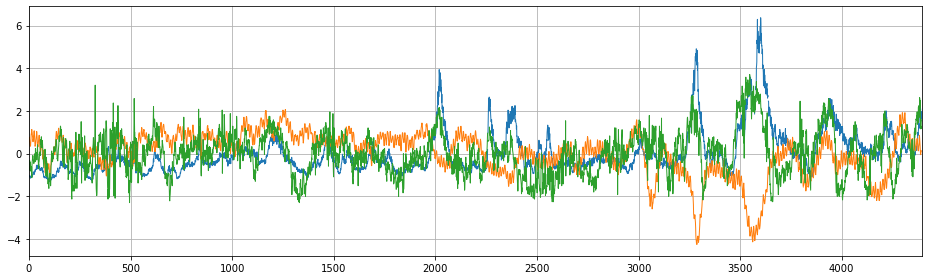

In [5]:
# Load time-series
data = np.loadtxt('hurricane_data.csv', delimiter=',', skiprows=1, usecols=(1,2,3)).T

# Normalize each variable independently
data_norm = data - np.nanmean(data, axis=1, keepdims=True)
data_norm /= np.sqrt(np.nanmean(data_norm ** 2, axis=1, keepdims=True))

# Plot time series
plot_ts(data_norm)
plt.show()

## Anomaly Detection

First, we will detect the three main anomalies in our time-series (which happen to be the three hurricanes) using MDI.

In [6]:
# Configure parameters for MDI algorithm
params = mdi.maxdiv_params_t()
mdi.libmaxdiv.maxdiv_init_params(params)  # initialize with default parameters
params.min_size[:] = [24] * len(params.min_size)  # anomalies should be at least 1 day long
params.max_size[:] = [120] * len(params.max_size)  # anomalies should be at most 5 days long
params.kl_mode = mdi.enums['MAXDIV_KL_UNBIASED']  # use unbiased KL divergence
params.preproc.normalization = mdi.enums['MAXDIV_NORMALIZE_NONE']  # we normalized our data already, so MDI doesn't need to
params.preproc.embedding.kt = 3  # time-delay embedding dimension

# Construct detection pipeline using the parameters above
pipeline = mdi.libmaxdiv.maxdiv_compile_pipeline(params)

[(3518, 3638, 371.43791109657224), (3253, 3329, 131.6795716464537), (1139, 1259, 108.13643215178084)]


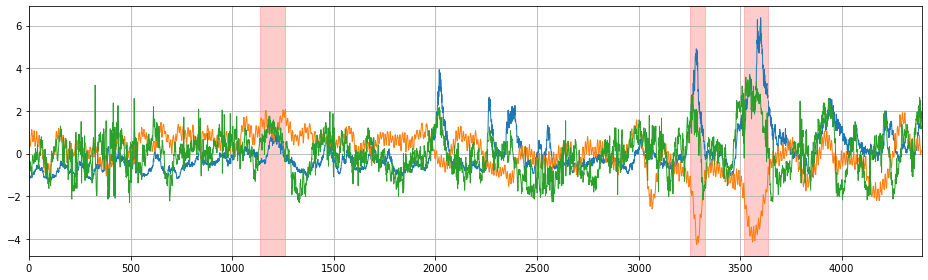

In [7]:
# Run detector
detections = mdi.maxdiv_exec(data_norm, pipeline, 3)
print(detections)

plot_ts(data_norm, intervals=detections)
plt.show()

## Sampling of some Univariate Replacements

First, we will sample some replacements for a single variable (wind speed), because it is easier to inspect than a multivariate time-series.
This is not useful for attribution but just serves as a sanity check that the replacement algorithm works.

### First Anomaly

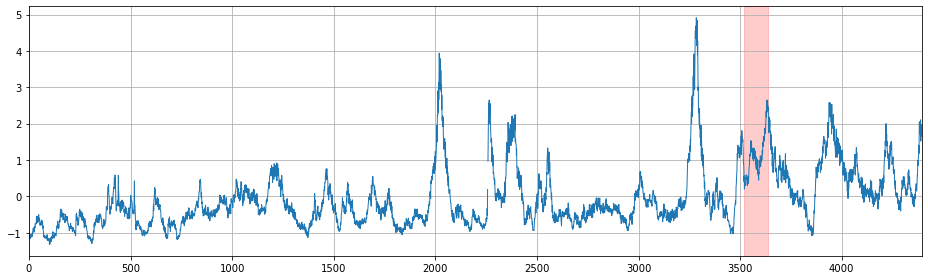

In [8]:
anon_ind = 0  # index of the anomaly
a, b, _ = detections[anon_ind]

replaced = data_norm[[0]].copy()
replaced[:, a:b] = sample_replacement(data_norm[[0]], (a, b), params.preproc.embedding.kt)

plot_ts(replaced, intervals=[detections[anon_ind]])
plt.show()

Let's take a closer look at the original data and the replacement by zooming in.

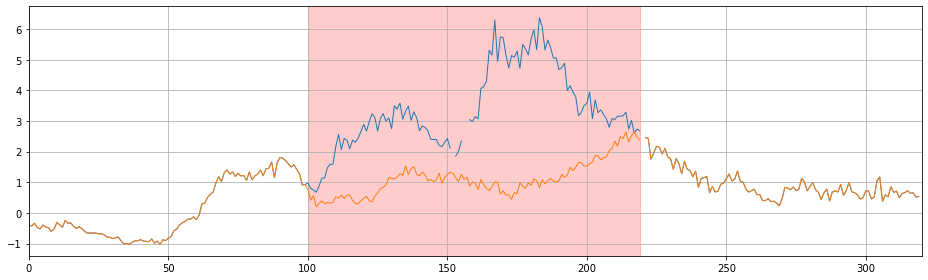

In [9]:
data_and_replacement = np.stack([data_norm[0], replaced[0]], axis=0)
plot_ts(data_and_replacement[:, a-100:b+100], intervals=[(100, 100 + b - a)])
plt.show()

### Second Anomaly

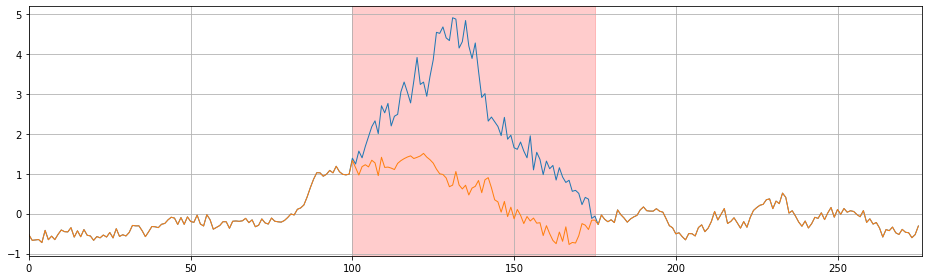

In [10]:
anon_ind = 1
a, b, _ = detections[anon_ind]

replaced = data_norm[[0]].copy()
replaced[:, a:b] = sample_replacement(data_norm[[0]], (a, b), params.preproc.embedding.kt)

data_and_replacement = np.stack([data_norm[0], replaced[0]], axis=0)
plot_ts(data_and_replacement[:, a-100:b+100], intervals=[(100, 100 + b - a)])
plt.show()

### Third Anomaly

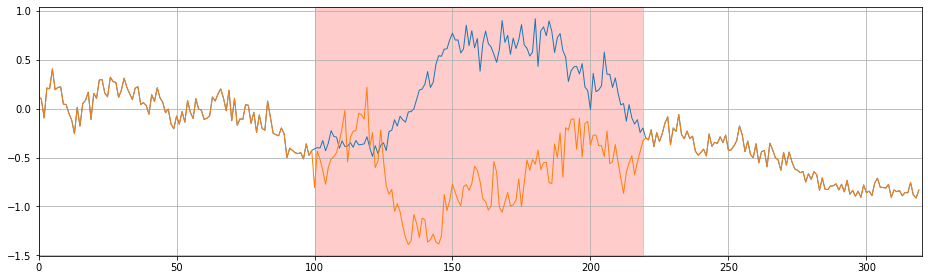

In [11]:
anon_ind = 2
a, b, _ = detections[anon_ind]

replaced = data_norm[[0]].copy()
replaced[:, a:b] = sample_replacement(data_norm[[0]], (a, b), params.preproc.embedding.kt)

data_and_replacement = np.stack([data_norm[0], replaced[0]], axis=0)
plot_ts(data_and_replacement[:, a-100:b+100], intervals=[(100, 100 + b - a)])
plt.show()

## Anomaly Attribution

Now we will replace all three variables jointly within the first detected anomaly and re-score the interval using MDI.

Old score: 371.43791109657224
New score: 40.47871944876905


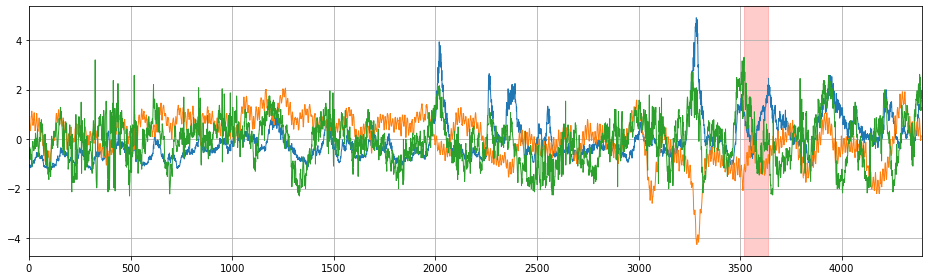

In [15]:
anon_ind = 0
a, b, old_score = detections[anon_ind]

# Replace detected interval
replaced = data_norm.copy()
replaced[:, a:b] = sample_replacement(data_norm, (a,b), td=params.preproc.embedding.kt)

# Re-score interval
new_score = mdi.maxdiv_score_intervals(replaced, pipeline, [(a,b)])[0][2]

# Print anomaly score before and after replacement
print(f'Old score: {old_score}')
print(f'New score: {new_score}')

# Plot time-series with the replaced interval
plot_ts(replaced, intervals=[(a,b)])
plt.show()

Since we replaced the all variables, the anomaly score of the interval was significantly reduced. It is now close to normal.

Let's take a closer look at the replacement for the first variable. As opposed to the univariate examples above, the replacement is now conditioned on the joint distribution of all variables in the left and right context.

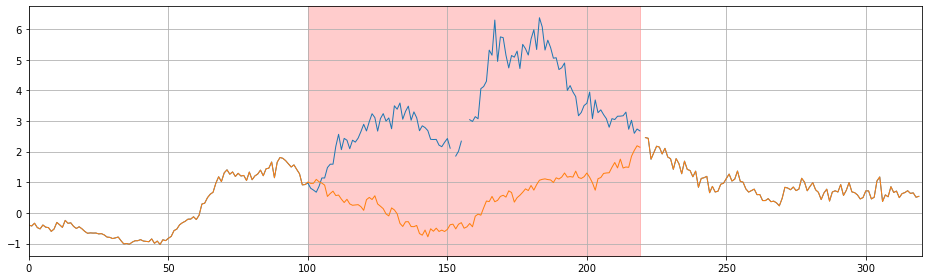

In [16]:
data_and_replacement = np.stack([data_norm[0], replaced[0]], axis=0)
plot_ts(data_and_replacement[:, a-100:b+100], intervals=[(100, 100 + b - a)])
plt.show()

Now we come to the actual attribution part: For all subsets of variables, we sample a replacement and re-compute it's anomaly score. We would then attribute the anomaly to the variables whose replacement results in the lowest score. However, subsets of different cardinality cannot be compared with each other, since replacing more variables will always result in lower scores.

In [17]:
# Iterate over all detections
for i, (a, b, score) in enumerate(detections, 1):
    print(f'\nDetection #{i} (Score: {score})')
    
    # Iterate over all non-empty subsets of variables
    for r in range(1, data_norm.shape[0] + 1):
        for d in itertools.combinations(range(data_norm.shape[0]), r):
            
            # All non-replaced variables form the set of observed variables to condition on
            d_obs = np.setdiff1d(np.arange(data_norm.shape[0]), d)
            
            # Conditonal replacement
            replaced = data_norm.copy()
            replaced[d, a:b] = sample_replacement(data_norm, (a, b), td=params.preproc.embedding.kt, cond=d_obs)

            # Re-score new interval
            new_score = mdi.maxdiv_score_intervals(replaced, pipeline, [(a, b)])[0][2]
            print('var {}: {}  {}'.format(d, new_score, '<' if new_score < score else ''))


Detection #1 (Score: 371.43791109657224)
var (0,): 248.895597918895  <
var (1,): 349.0647297891343  <
var (2,): 352.3839661280811  <
var (0, 1): 125.31924182983524  <
var (0, 2): 175.66583587149765  <
var (1, 2): 369.2172716298406  <
var (0, 1, 2): 84.09040293052693  <

Detection #2 (Score: 131.6795716464537)
var (0,): 104.64876554688136  <
var (1,): 113.87579512285323  <
var (2,): 137.83572329379993  
var (0, 1): 35.76057224755841  <
var (0, 2): 81.5390855544904  <
var (1, 2): 114.87284825516456  <
var (0, 1, 2): 35.352047987856594  <

Detection #3 (Score: 108.13643215178084)
var (0,): 106.84919142200515  <
var (1,): 98.12032580089686  <
var (2,): 80.67331902968508  <
var (0, 1): 112.36702402357243  
var (0, 2): 62.46701774940487  <
var (1, 2): 54.62068514804645  <
var (0, 1, 2): 49.14102574681662  <
